

# RNN for Time Series

RNNs are used for sequence modeling. This tutorial will look at a time series data to be modeled and predicted using RNNs. 

In [77]:
#
# Import Libraries
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

## Data

We will use retail data for time-series modeling. 

Link to the dataset:
 https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at:
https://www.census.gov/retail/marts/about_the_surveys.html

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted
Frequency:  Monthly

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

### Read data first -  Use index_col = 'DATE' and 'parse_dates = True' as a parameter.

In [91]:
# Your code to read data
df = pd.read_csv('MRTSSM448USN.csv')
# Print first few rows of data

df.head(5)

,DATE,MRTSSM448USN
0,1992-01-01,6938.0
1,1992-02-01,7524.0
2,1992-03-01,8475.0
3,1992-04-01,9401.0
4,1992-05-01,9558.0


Does the sales column has any name?

If no, set the name of the colum as 'Sales'.

In [79]:
# Set name of column as 'Sales'. Use - df.columns 
df.rename(columns={'MRTSSM448USN':'Sales'}, inplace=True)
df.columns

print(df.dtypes)



DATE      object
Sales    float64
dtype: object


Plot your data - Year vs Sales

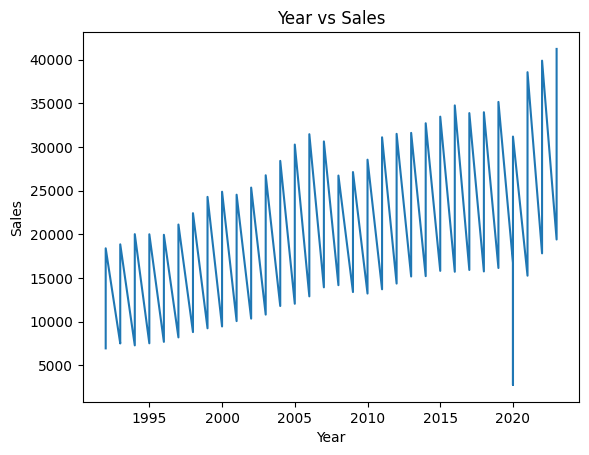

In [80]:
# Your code to plot Year vs Sales. Use either matplot library of pandas dataframe
year = pd.to_datetime(df['DATE'])
year = year.dt.year
plt.plot(year, df['Sales'])
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Year vs Sales')
plt.show()

### Next we will do Train Test Split. 

We will use last 1.5 year (18 month) samples for testing. Rest is for training.

In [94]:
# Assign variable test size = 18
# Store length of data in variable length.
# store training size in varialable train_size (Remember training size = total size - test_size)
test_size = 18
data_length = len(df)
data_length
train_size = data_length - test_size
train_size


test_index = train_size

train = df.iloc[:test_index]

Now, we will find the indexes of the test data. Remember, these are the last 18 indexes in the pandas dataframe.

In [82]:
#Assign the start of test index in data frame to variable test_index.  Remember, it is equal to the length of dataframe - test size

Next, we will separate train and test datasets.

In [93]:
# Store all data from 0 to test_index in variable train. Hint - Use df.iloc.
# Store everthing from test_index to the last sample in test variable. Hint - Use df.iloc.

test = df.iloc[test_index:]

In [84]:
# Print the size of the train data
train.shape, test.shape
# Print the size of the test data
# Print the train data
# Print the test data
print(test)


           DATE    Sales
366  2022-07-01  24904.0
367  2022-08-01  26049.0
368  2022-09-01  23629.0
369  2022-10-01  24787.0
370  2022-11-01  28645.0
371  2022-12-01  39883.0
372  2023-01-01  19405.0
373  2023-02-01  20937.0
374  2023-03-01  24963.0
375  2023-04-01  24700.0
376  2023-05-01  26557.0
377  2023-06-01  24809.0
378  2023-07-01  25364.0
379  2023-08-01  27143.0
380  2023-09-01  23840.0
381  2023-10-01  24438.0
382  2023-11-01  29150.0
383  2023-12-01  41228.0


In [85]:
print(train.dtypes)

DATE      object
Sales    float64
dtype: object


### In Neural Networks, we need to Scale Data between 0-1

In [86]:
from sklearn.preprocessing import MinMaxScaler

In [87]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

ValueError: could not convert string to float: '1992-01-01'

In [ ]:
#
# Check if the data has been scaled properly
#

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

# We will use 12 months as input and then predict the next month out


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [ ]:
X, y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

### Create the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU

import tensorflow as tf

In [ ]:
# We're only using one feature in our time series
n_features = 1

# Define your own models. 

Use 1. SimpleRNN, LSTM, or GRU neural network.

APIs:
https://keras.io/api/layers/recurrent_layers/

In [ ]:
# 
# Your code to create your own model
#


In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mse')

### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [ ]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Your code to create an object early-stop.

Now, fit your model.

In [ ]:
# Your code to fit your model.

In [ ]:
# Get Losses from dataframe (hint - model.history.history)- See previous week tutorial.
# Plot losses in the dataframe.

## Evaluate on Test Data

In [ ]:
first_eval_batch = scaled_train[-length:]

In [ ]:
n_input = 12
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)


In [ ]:
# compare with the true result:
scaled_test[0]

#### Try predicting the series!

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for 
    # grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

# Check and plot predictions

In [ ]:
# Print the test variable.

In [ ]:
# Your code to plot actual sales and predictions.

# Retrain and Forecasting

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, 
                                scaled_full_data, length=length, batch_size=1)

In [ ]:
#
# Use any neural network model based on RNN
#
# Create the model


In [ ]:
# compile the model

In [ ]:
# use early_stop

In [ ]:
# fit the model

In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for  grabbing just the number instead of [array])
    
    
    # store prediction forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value


In [ ]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [ ]:
df

In [ ]:
forecast_index = pd.date_range(start='2024-01-01',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

In [ ]:
# Plot sales - Values in dataframe

In [ ]:
# Plot forecast - Values in forecast_df

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2022-01-01','2025-01-01')

# Try the same example with a LSTM and GRU! 
Hint: Use LSTM instead of SimpleRNN!